<a href="https://colab.research.google.com/github/MoheEdeen/Deepfake-Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deepfake Audio Detection Project
#### CMSC320: Introduction to Data Science  
**Contributors:** Mohe Edeen Abu Maizer, Safwah Ashraf
**Repository:** https://github.com/MoheEdeen/Deepfake-Detection
**Date:** July 2025

---

## Project Overview

This project investigates deepfake audio detection using supervised learning. We analyze labeled `.wav` files from the **Fake-or-Real (FoR)** dataset to extract acoustic features and distinguish between real and synthetic speech generated by advanced TTS models. Our goal is to perform data preprocessing, statistical analysis, and hypothesis testing to uncover distinguishing traits between authentic and fake voice recordings.

---

In [ ]:
import pathlib
import pandas as pd
import numpy as np
import soundfile as sf
import scipy.stats as sc

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

To begin, we extracted audio data from two separate directories, one containing normalized audio clips but balanced in terms of gender and class and normalized in terms of sample rate, volume and number of channels. (`for-norm`) and the other containing rerecorded versions; to simulate a scenario where an attacker sends an utterance through a voice channel such as a phone call or a voice message (`for-rerecorded`). Each version includes `training`, `testing`, and `validation` subfolders, which are further divided into `real` and `fake` classes.

Using a nested loop structure, we traversed each `.wav` file and used the `soundfile` library (`sf.info()`) to extract attributes such as:

- Full file path
- Dataset version (`norm` or `rerec`)
- Data split (`training`, `testing`, `validation`)
- Label (`real` or `fake`)
- Numeric label ID
- Duration (in seconds)
- Samplerate (Hz)

These entries were stored in a Pandas DataFrame.

# IMPORTANT NOTE:

This code is commented out as we saved the results to a csv file for faster processing, if you want to run these cells keep in mind they do take a lot of time to run.

---

In [ ]:
# dataset_path = "/content/drive/MyDrive/CMSC320/Project"
# dataset_norm = pathlib.Path(dataset_path + "/for-norm/for-norm/")
# dataset_norm.mkdir(parents=True, exist_ok=True)
# dataset_rerec =pathlib.Path(dataset_path + "/for-rerec/for-rerecorded")
# dataset_rerec.mkdir(parents=True, exist_ok=True)

In [ ]:
# rows = []

# for version_name, dataset_path in [("norm", dataset_norm), ("rerec", dataset_rerec)]:
#     for split_folder in dataset_path.iterdir():
#         for label_folder in split_folder.iterdir():
#             for wav_file in label_folder.iterdir():
#               curr_file_path = str(wav_file)
#               curr_version = version_name
#               curr_type_of_file = split_folder.name
#               curr_label = label_folder.name
#               curr_label_id = 1 if curr_label == "real" else 0
#               curr_sound_file = sf.info(wav_file)
#               curr_duration = curr_sound_file.duration
#               curr_samplerate = curr_sound_file.samplerate
#               curr_row = {"filepath": curr_file_path, "version": curr_version, "type": curr_type_of_file, "label": curr_label, "label_id": curr_label_id, "duration": curr_duration, "samplerate": curr_samplerate}
#               # print(curr_row)
#               rows.append(curr_row)
# df = pd.DataFrame(rows)
# display(df)


In [ ]:
# from google.colab import files
# df.to_csv("audio_data.csv", index=False)
# files.download("audio_data.csv")

In [212]:
csv_file = "/content/drive/MyDrive/CMSC320/Project/audio_data.csv"
df = pd.read_csv(csv_file)
df.reset_index(drop=True, inplace=True)
display(df)

,filepath,version,type,label,label_id,duration,samplerate
0,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.190375,16000
1,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,1.443375,16000
2,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,3.116687,16000
3,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.540125,16000
4,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,3.261563,16000
...,...,...,...,...,...,...,...
18374,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.975313,16000
18375,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.985875,16000
18376,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.986250,16000
18377,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.920313,16000


# Statistical Method 1 – Visualizing Duration Distribution (Box and Whisker Plot)

To better understand how audio duration differs between real and fake samples, we use matplotlib to plot a box and whisker plot of the `duration` feature grouped by label.

When looking at the boxplot for the duration grouped by the audio clips, we can see that both types share a similar median which is around 2 second clips. However there are some outliers as seen by the second plot that can go more than 20 seconds (for only one type).

Such outliers would cause some issues down the line if we do not exclude them, as our model might be trained that the longer the clip the mroe likely it is real, which is untrue. This can be concluded because for the fake plot, the outliers do not exceed 6 seconds (unlike the real), yet they do go as low as 0.1 seconds unlike the real clips.

Another conclusion we can observe is that for the real clips there is a much tighter quartile range, unlike the fake ones which vary more widely.

Our null hypothesis is that the distribution of the duration of real and fake audio samples in the entire dataset is balanced, where no audio type has too high values or low values. Our alternative hypothesis is that the distribution of real and fake audio duration in the dataset is imbalanced, We have chosen 0.05 as our significance level which means if the P-value is less that 0.05, we will reject the null hypothesis.

---

/tmp/ipython-input-213-3143717109.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
/tmp/ipython-input-213-3143717109.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])


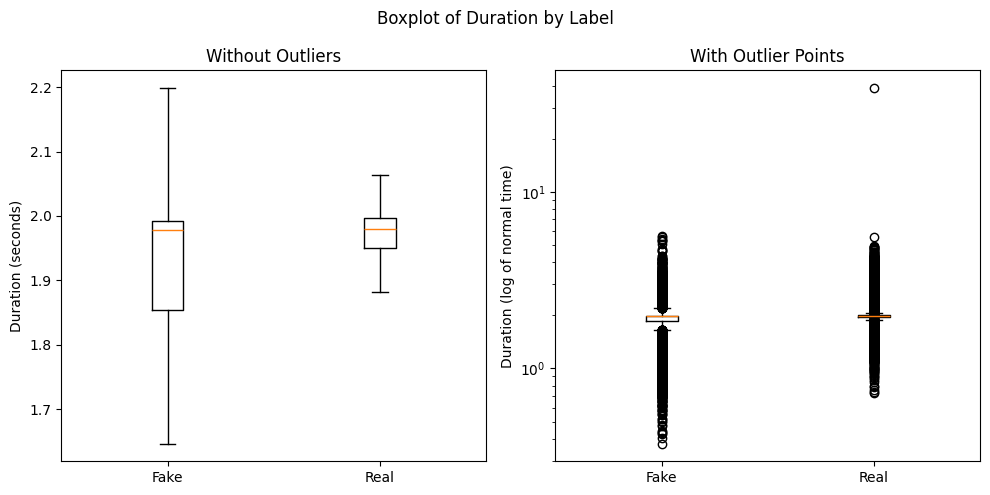

In [213]:
grouped_label_duration = [df[df["label"] == "fake"]["duration"], df[df["label"] == "real"]["duration"]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
axs[0].set_title("Without Outliers")
axs[0].set_ylabel("Duration (seconds)")

axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])
axs[1].set_title("With Outlier Points")
axs[1].set_ylabel("Duration (log of normal time)")
axs[1].set_yscale("log")

fig.suptitle("Boxplot of Duration by Label")
plt.tight_layout()
plt.show()

### Removing Outliers from Duration

Now that we can see how the duration is distributed, we want to remove the outliers before moving on. The reason for this is to avoid our model from learning patterns that don't really help. For example, if some real clips are way too long, the model might think real means longer, which is not true. We calculate the IQR (interquartile range) for both fake and real durations to find these outliers. Any duration that is way too small or too large (beyond the lower or upper fence) will be removed from the dataframe.

In [214]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

fake_duration = np.log2(df[df["label"] == "fake"]["duration"])
real_duration = np.log2(df[df["label"] == "real"]["duration"])

Q1_fake = fake_duration.quantile(0.25)
Q3_fake = fake_duration.quantile(0.75)

Q1_real = real_duration.quantile(0.25)
Q3_real = real_duration.quantile(0.75)

IQR_fake = Q3_fake - Q1_fake
IQR_real = Q3_real - Q1_real

lower_fake_fence = Q1_fake - (3 * IQR_fake)
upper_fake_fence = Q3_fake + (3 * IQR_fake)

lower_real_fence = Q1_real - (3 * IQR_real)
upper_real_fence = Q3_real + (3 * IQR_real)

upper_fake_array = np.where((df["label"] == "fake") & (np.log2(df["duration"]) >= upper_fake_fence))[0]
lower_fake_array = np.where((df["label"] == "fake") & (np.log2(df["duration"]) <= lower_fake_fence))[0]

upper_real_array = np.where((df["label"] == "real") & (np.log2(df["duration"]) >= upper_real_fence))[0]
lower_real_array = np.where((df["label"] == "real") & (np.log2(df["duration"]) <= lower_real_fence))[0]

df.drop(index=upper_fake_array, inplace=True)
df.drop(index=lower_fake_array, inplace=True)

df.drop(index=upper_real_array, inplace=True)
df.drop(index=lower_real_array, inplace=True)

print(upper_fake_fence, lower_real_fence, upper_real_fence, lower_real_fence)
df.reset_index(drop=True, inplace=True)
display(df)

1.305635921629112 0.8642228714769554 1.0969957505962125 0.8642228714769554


,filepath,version,type,label,label_id,duration,samplerate
0,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,1.932500,16000
1,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.083188,16000
2,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.084125,16000
3,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.037500,16000
4,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.028500,16000
...,...,...,...,...,...,...,...
14024,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.975313,16000
14025,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.985875,16000
14026,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.986250,16000
14027,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.920313,16000


### Plotting Duration Distribution After Outlier Removal

After removing outliers, we now replot the boxplot to see how the cleaned data
looks like. This helps us check if the removal worked and if the distributions look more balanced.

/tmp/ipython-input-215-3143717109.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
/tmp/ipython-input-215-3143717109.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])


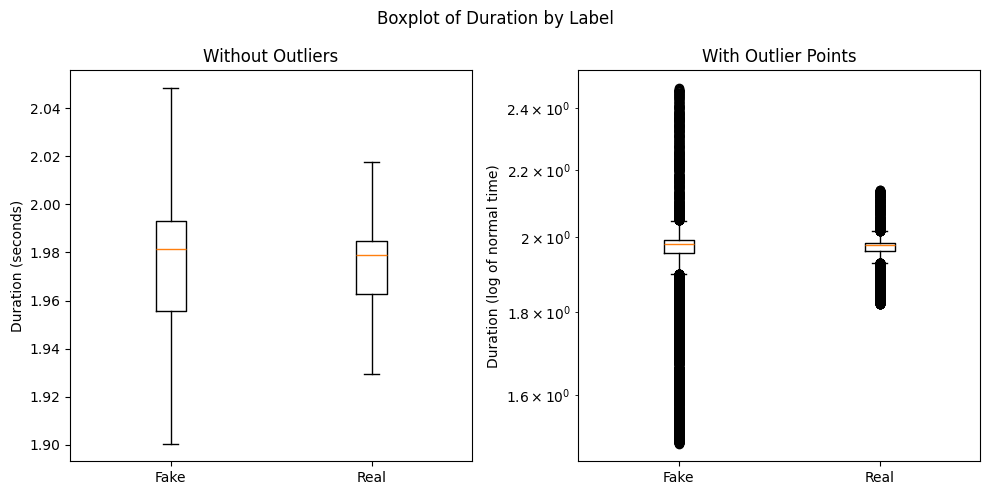

In [215]:
grouped_label_duration = [df[df["label"] == "fake"]["duration"], df[df["label"] == "real"]["duration"]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
axs[0].set_title("Without Outliers")
axs[0].set_ylabel("Duration (seconds)")

axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])
axs[1].set_title("With Outlier Points")
axs[1].set_ylabel("Duration (log of normal time)")
axs[1].set_yscale("log")

fig.suptitle("Boxplot of Duration by Label")
plt.tight_layout()
plt.show()

# Statistical Method 2 – Class Distribution Analysis (Bar Plot + Frequency Table)

For the first method, we first look at the `label` column in order to see the balance between both the `real` and the `fake` classes in the data. The main reason for this is to avoid bias.

To do this, we went with a bar plot in order to visualize the count/frequency of each, this was done thorugh `.value_counts` in the `pandas` library. The bar chart presented compares both the value counts of **real** and **fake** clips.

Our null hypothesis is that the distribution of real and fake audio samples  in the entire dataset is balanced; that is, both classes occur with approximately equal frequency. Our alternative hypothesis is that the distribution of real and fake audio samples in the dataset is imbalanced, in which one class occurs significantly more frequently than the other. We have chosen 0.05 as our significance level which means if the P-value is less that 0.05, we will reject the null hypothesis.

---

In [216]:
observed_fake_real_count = df['label'].value_counts().loc[['real','fake']].values

expected_fake_real_count = [len(df) / 2, len(df) / 2]
print(expected_fake_real_count, observed_fake_real_count)

stat, p_value = sc.chisquare(f_obs=observed_fake_real_count, f_exp=expected_fake_real_count)

print(f"Chi-square statistic: {stat:.2f}")
print(f"P-value: {p_value:.6f}")

[7014.5, 7014.5] [6200 7829]
Chi-square statistic: 189.15
P-value: 0.000000


When looking at our p-value it is clearly less than 0.05, which means that the real and fake values are not balanced which may cause errors down the line. In order to fix this, we will process the data for both of the columns and will resample the fake types due to them being larger than the real ones. After that is done we downsample the fake types so that they become equal to the real types.

In [217]:
from sklearn.utils import resample
df_real = df[df.label == 'real']
df_fake = df[df.label == 'fake']

df_fake_downsample = resample(df_fake, replace=False, n_samples=len(df_real), random_state=0)

df = pd.concat([df_real, df_fake_downsample])
df.reset_index(drop=True, inplace=True)
display(df)

,filepath,version,type,label,label_id,duration,samplerate
0,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,1.932500,16000
1,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.083188,16000
2,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.084125,16000
3,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.037500,16000
4,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.028500,16000
...,...,...,...,...,...,...,...
12395,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,validation,fake,0,1.980000,16000
12396,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,fake,0,1.990813,16000
12397,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,fake,0,1.983125,16000
12398,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,fake,0,1.983188,16000


In [218]:
observed_fake_real_count = df['label'].value_counts().loc[['real','fake']].values

expected_fake_real_count = [len(df) / 2, len(df) / 2]
print(expected_fake_real_count, observed_fake_real_count)

stat, p_value = sc.chisquare(f_obs=observed_fake_real_count, f_exp=expected_fake_real_count)

print(f"Chi-square statistic: {stat:.2f}")
print(f"P-value: {p_value:.6f}")

[6200.0, 6200.0] [6200 6200]
Chi-square statistic: 0.00
P-value: 1.000000


After resampling our data, it is clear that now both types are balanced which is indicated by having a p_value > 0.05 making our null hypothesis valid.

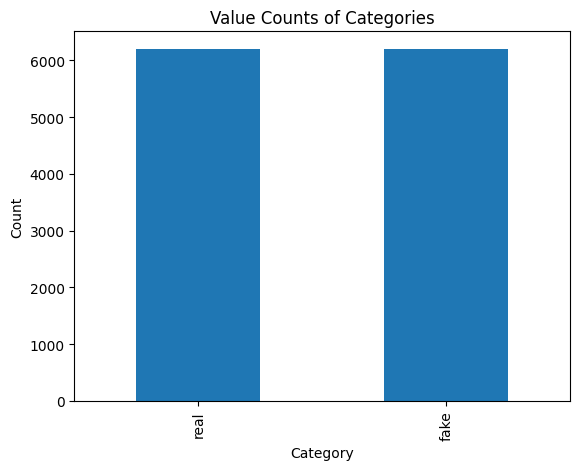

,count
label,
real,6200
fake,6200


In [219]:
fake_real_count = df['label'].value_counts()
fake_real_count.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of Categories')
plt.show()
fake_real_count

Due to this conclusion, we can therefore be assure that when we train our model with the dataset we will not result in some biases that will alter our model and its results. This also makes the process simpler, as we will not have to resample or add weighting to our data.


# Statistical Method 3 (Balance Across Splits + Statistical Testing)
Having similar numbers of real and fake audio samples within each of the training, testing, and validation sets is very important for training a fair and effective machine learning model. If one class for example, fake audio, have significantly more samples in any one of these sets than other classes, the model might become biased and perform poorly when trying to detect the classes with smaller samples in that set. So, to make sure the model learns fairly from both classes, we need to confirm that real and fake samples are balanced in each data split. To do that, we are using a statistical test called the Chi-square test to check if the numbers of real and fake sampels are same or atleast close across the training, testing, and validation sets.

Our null hypothesis is that the distribution of real and fake audio samples is similar/close for all the three data splits. Our alternative hypothesis is that the distribution is significantly different in atleast one split. We have chosen 0.05 as our significance level which means if the P-value is less that 0.05, we will reject the null hypothesis.

The Chi-Square test:

In [220]:
cont_table = pd.crosstab(df['type'], df['label'])

result = chi2_contingency(cont_table)

print(f"The Chi-square statistic:{result.statistic: .2f}")
print(f"The P-value:{result.pvalue:}")

The Chi-square statistic: 109.90
The P-value:1.3628965596403384e-24


As we can see from the above calculation, the chi-square test gave us a statistic of 2.85 and a p-value of 0.24. Since the p-value is 0.24 which is higher than our significance level of 0.05, we fail to reject the null hypothesis. This means we can confidently conclude that there is no significant difference in how real and fake audio samples are distributed across the splits. This balance is good because it will help the model learn from all parts of the data fairly and will give us reliable and unbiased predications.

Here's a plot that shows the distribution of real and fake audio samples in testing, training, and validation sets:

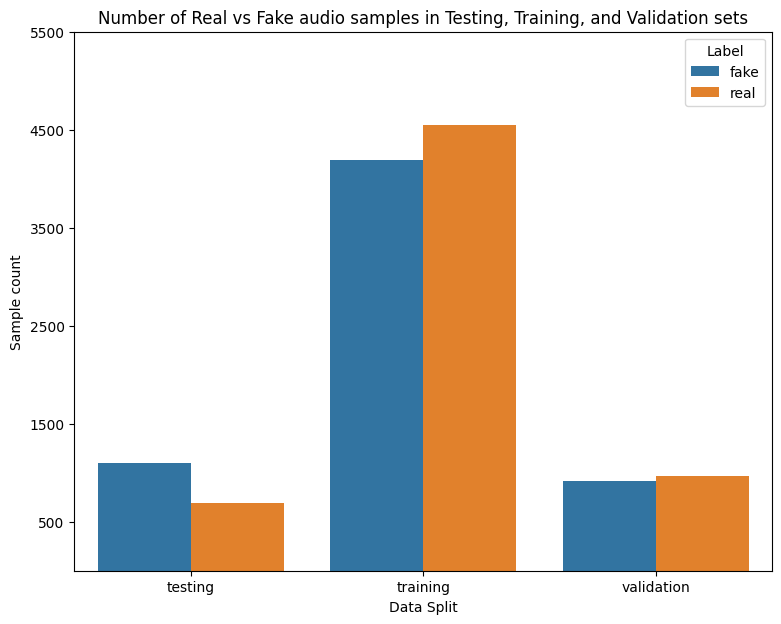

In [221]:
data = df.groupby(['type', 'label']).size().reset_index(name = 'samples')

plt.figure(figsize=(9,7))
sns.barplot(data = data, x = 'type', y = 'samples', hue = 'label')
plt.title('Number of Real vs Fake audio samples in Testing, Training, and Validation sets')
plt.xlabel('Data Split')
plt.ylabel('Sample count')
plt.legend(title = 'Label')
plt.yticks(([500, 1500, 2500, 3500, 4500, 5500]))

plt.show()